In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import add_dummy_feature
from sklearn import linear_model

plt.rcParams['figure.figsize']=(5,5)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)

# Formulación probabilística de un problema de clasificación

$$
  y^* = \mathop{\arg\max}\limits_{y} p\big(y|{\bf x}\big)
$$

Es decir, buscamos la etiqueta óptima $y^*$, que será la etiqueta más probable para el ejemplo dado.

Evidentemente, esta formulación exige construir un modelo probabilístico de la etiqueta o clase condicionado a los ejemplos.

Esto se puede hacer de dos modos:
1. Estimando directamente $p(y|x)$
2. Utilizando modelado bayesiano

El primero **ya lo hemos hecho** cuando aprendimos la regresión logística.

El segundo se explica en el próximo cuaderno y siguientes.

# Pérdida de la regresión logística

Cuando explicamos la función logística dejamos pendiente aprender una función de pérdida con la que podamos aplicar descenso del gradiente.

Desde el punto de vista de un modelo probabilístico, una manera de guiar el ajuste de los parámetros es haciendo que estos maximicen la probabilidad con la que el clasificador toma una decisión para el conjunto de datos de entrenamiento dado.

Es decir, para una ejemplo dado ${\bf x}^{(i)}$ queremos que el clasificador:
-  maximice el valor $~p(y=1|{\bf x}^{(i)})~$ cuando la etiqueta asociada a este ejemplo $y^{(i)}=1$;
-  y que maximice el valor $~1-p(y=1|{\bf x}^{(i)})~$ cuando la etiqueta asociada a este ejemplo $y^{(i)}=0$.

Ambas condiciones se pueden reunir en la siguiente expresión:
$$
\max \left( p(y=1|{\bf x}^{(i)}) ^ {y^{(i)}} \big(1- p(y=1|{\bf x}^{(i)}) ^ {1-y^{(i)}}\big) \right)
$$

**¿Por qué?**

- $p(y=1|{\bf x}^{(i)}) ^ {y^{(i)}} $ es la probabilidad con la que el clasificador acertaría al predecir que la etiqueta $y^{(i)}=1$ para este ejemplo $i$.
- $1-p(y=1|{\bf x}^{(i)}) ^ {1-y^{(i)}} $ es la probabilidad con la que el clasificador acertaría al predecir que la etiqueta $y^{(i)}=0$ para este ejemplo $i$.

En clasificación binaria NO hay más posibilidades así que el contenido del parentesis que se quiere maximizar es o bien uno o el otro.

## Ejemplo

Sea el siguiente conjunto de entrenamiento "de juguete" compuesto por las columnas $x_{j=1,\ldots,D}$ de las características junto con la columna $y$ de la etiqueta.

Además se ha añadido una columna con la probabilidad estimada por el clasificador de que la etiqueta sea "1" para cada ejemplo.

| id |$x_1$|$x_2$|$\ldots$|$x_D$|  $y$ | $p(y=1|x)$ |
|:----:|-----:|:-----:|:--------:|:---:|:----:|:----------:|
| 1  |$ 0.2$|$0.5$|$\ldots$|$1$|$1$|$ 0.76 $    |
| 2  |$-0.6$|$0.1$|$\ldots$|$3$|$0$|$ 0.66 $    |
| 3  |$ 0.3$|$0.7$|$\ldots$|$4$|$1$|$ 0.56 $    |
| 4  |$ 0.7$|$0.9$|$\ldots$|$2$|$1$|$ 0.94 $    |
| 5  |$-0.3$|$0.3$|$\ldots$|$1$|$0$|$ 0.16 $    |
|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|
|$N$ |$-0.2$|$0.1$|$\ldots$|$5$|$1$|$ 0.76 $    |

**Ejemplo 1**
El clasificador calcula una probabilidad de 0.76 a la etiqueta correcta, es decir:
$$ (0.76)^{(1)} (1-0.76)^{(1-1)} = (0.76)^1 (0.24)^0 = 0.76 $$

**Ejemplo 2**
El clasificador calcula una probabilidad de 0.34 a la etiqueta correcta, es decir:
$$ (0.66)^{(0)} (1-0.66)^{(1-0)} = (0.66)^0 (0.34)^1 = 0.34 $$

**Ejemplo 3**
El clasificador calcula una probabilidad de 0.56 a la etiqueta correcta, es decir:
$$ (0.56)^{(1)} (1-0.56)^{(1-1)} = (0.56)^1 (0.44)^0 = 0.56 $$

**Ejemplo 4**
El clasificador calcula una probabilidad de 0.94 a la etiqueta correcta, es decir:
$$ (0.94)^{(1)} (1-0.94)^{(1-1)} = (0.94)^1 (0.06)^0 = 0.94 $$

**Ejemplo 5**
El clasificador calcula una probabilidad de 0.84 a la etiqueta correcta, es decir:
$$ (0.16)^{(0)} (1-0.16)^{(1-0)} = (0.16)^0 (0.84)^1 = 0.84 $$

Lo "ideal" sería que las probabilidades fueran lo más altas posibles.<br>
Por tanto queremos modificar los parámetros en el sentido de MAXIMIZAR estas probabilidades, que surgen de la expresión dada arriba.

PERO **NO** podemos maximizar $N$ probabilidades distintas (una por cada ejemplo). Queremos maximizar la probabilidad de **TODO** el conjunto de ejemplos de entrenamiento.

Como los ejemplos son iid la probabilidad conjunta de todos ellos es el producto de cada uno. Así que nuestro objetivo es
$$
\max \prod\limits_{i=1}^{N} \left( p(y=1|{\bf x}^{(i)}) ^ {y^{(i)}} \big(1- p(y=1|{\bf x}^{(i)}) ^ {1-y^{(i)}}\big) \right)
$$
Podemos cambiar el producto por sumas si tomamos logarítmos,
$$
\max \sum\limits_{i=1}^{N}  \log \left( p(y=1|{\bf x}^{(i)}) ^ {y^{(i)}} \big(1- p(y=1|{\bf x}^{(i)}) ^ {1-y^{(i)}}\big) \right)
$$
Si en vez de maximizar queremos minimizar (por ejemplo porque tenemos un algoritmo de descenso de gradiente ya programado), entonces basta con cambiar el signo
$$
\min \sum\limits_{i=1}^{N}  -\log \left( p(y=1|{\bf x}^{(i)}) ^ {y^{(i)}} \big(1- p(y=1|{\bf x}^{(i)}) ^ {1-y^{(i)}}\big) \right)
$$
Finalmente, manipulando con el logaritmo y el parentesis llegamos a
$$
\min \sum\limits_{i=1}^{N}  
- {y^{(i)}} \log \big( p(y=1|{\bf x}^{(i)}) \big)
- ({1-y^{(i)}}) \log \big( 1- p(y=1|{\bf x}^{(i)}) \big)
$$

En definitiva, como la regresión logística devuelve directamente $~p(y=1|{\bf x}^{(i)}; {\bf w})~$, podemos utilizar la siguiente función de pérdida
$$
\mathcal{L}_{\rm log} = \sum\limits_{i=1}^{N}  
- {y^{(i)}} \log \big( p(y=1|{\bf x}^{(i)}) \big)
- ({1-y^{(i)}}) \log \big( 1- p(y=1|{\bf x}^{(i)}) \big),
$$

llamada **log-loss**, para encontrar los parámetros mediante descenso del gradiente.

Por supuesto, a esta pérdida se le pueden añadir términos de regularización L1, L2 o ElasticNet.

Lo interesante de esta pérdida es que tiene una interpretación probabilística.

**Esta función de pérdida busca maximizar la probabilidad de las etiquetas dados los datos.**

> _Recuerda que hasta este momento, la manera de aprender los parámetros de una clasificador lineal era mediante pérdidas típicas de regresión como MSE o MAE, y después aplicabamos una función logística para obtener estimaciones de probabilidad._

# La entropía cruzada como función de pérdida.
En un problema de clasificación binario podemos interpretar la etiqueta verdadera (0 o 1) como la probabilidad de que el ejemplo pertenezca a la clase "positiva"; es decir:
- si $~y^{(i)}=0~$ quiere decir que la probabilidad de que el ejemplo $~{\bf x}^{(i)}~$ sea _positivo_ es **NULA**
- si $~y^{(i)}=1~$ quiere decir que la probabilidad de que el ejemplo $~{\bf x}^{(i)}~$ sea _positivo_ es **TOTAL**

Por otro lado, un modelo que estima $~p(y|x)~$ **NO** es tan _taxativo_; es decir que seguramente devuelve un valor en el intervalo $~(0,1).$

Con el siguiente código podemos representar las distribuciones de probabildad verdadera y estimada de un cierto ejemplo.


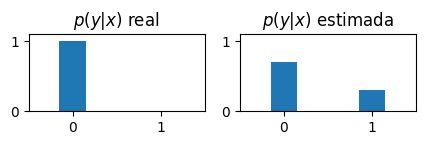

In [ ]:
Yi_true = 0    #<- 0 , 1
Yi_pred = 0.3  #<- (0,1)

p_YgivenX_true = [1-Yi_true, Yi_true]
p_YgivenX_pred = [1-Yi_pred, Yi_pred]

plt.rcParams['figure.figsize']=(5,1)
plt.subplot(121)
plt.bar([0,1],p_YgivenX_true, width=0.3, tick_label=[0,1])
plt.title('$p(y|x)$ real')
plt.axis([-.5, 1.5, 0, 1.1])
plt.subplot(122)
plt.bar([0,1],p_YgivenX_pred, width=0.3, tick_label=[0,1])
plt.title('$p(y|x)$ estimada')
plt.axis([-.5, 1.5, 0, 1.1])
plt.show()

¿ Existe alguna función de pérdida que **compare** ambas distribuciones y guíe el descenso de gradiente?

$\fbox{ Sí }$  la **entropía cruzada**


## Definición
La Entropía cruzada entre la distribución verdadera $p$ y la distribución estimada $\hat p$ es el valor esperado respecto a la distribución $p$ del $-\log \hat p$, es decir:
$$
\begin{align}
{\rm CE}(p,\hat p) &=  -\mathbb{E}_p \left[ \log \hat p \right] \\
&= -\sum\limits_{\forall y} p(y|x) \log \hat p(y|x)
\end{align}
$$

Para problemas de clasificación binaria $y=\{0,1\}$, y eliminando la notación de probabilidad condicionada para tener una expresión más sencilla, la entropía cruzada "binaria" (_Binary Cross Entropy_, BCE), se reduce a
$$
\begin{align}
{\rm BCE}(p,\hat p)
&=
p(y=1)(-\log \hat p(y=1)) +
p(y=0)(-\log \hat p(y=0)) \\
&=
-p(y=1)(\log \hat p(y=1))
-(1-p(y=1))(\log \hat p(y=0))
\\  
\end{align}
$$
que coincide con la log-loss para un único ejemplo. La extensión a $N$ es simplemente la suma de todas ellas.


# Resumen.

Se puede dar una interpretación probabilística desde varios puntos de vista.

1. La etiqueta estimada es la más probable<br>
$\rightarrow$ Planteamos la pérdida Log-loss.
2. La distribución de probabilidad estimada sobre las etiquetas debe ser lo más parecida posible a la distribución de probabilidad real<br>
$\rightarrow$ Planteamos la pérdida _Entropía cruzada_

$\fbox{Para problemas de clasificación binaria ambas coinciden}$

3. La etiqueta estimada es la más probable "a posteriori" (MAP)<br>
$\rightarrow$ Este es el planteamiento **Bayesiano**, que veremos en el siguiente cuaderno